# Exploratory Data Analysis & Preprocessing

## Data Preprocessing

### Importing the Dataset

In [137]:
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100


df = pd.concat(
    [
        pd.read_csv(
            f"data/OraclesElixir/{year}_LoL_esports_match_data_from_OraclesElixir.csv",
            dtype={"url": "str"}
        )
        for year in range(2020, 2025)
    ],
    ignore_index=True
)

rows, cols = df.shape
print(f"The CSV file has {rows} rows and {cols} columns.")

print(df.columns.tolist())


The CSV file has 666504 rows and 163 columns.
['gameid', 'datacompleteness', 'url', 'league', 'year', 'split', 'playoffs', 'date', 'game', 'patch', 'participantid', 'side', 'position', 'playername', 'playerid', 'teamname', 'teamid', 'champion', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'pick1', 'pick2', 'pick3', 'pick4', 'pick5', 'gamelength', 'result', 'kills', 'deaths', 'assists', 'teamkills', 'teamdeaths', 'doublekills', 'triplekills', 'quadrakills', 'pentakills', 'firstblood', 'firstbloodkill', 'firstbloodassist', 'firstbloodvictim', 'team kpm', 'ckpm', 'firstdragon', 'dragons', 'opp_dragons', 'elementaldrakes', 'opp_elementaldrakes', 'infernals', 'mountains', 'clouds', 'oceans', 'chemtechs', 'hextechs', 'dragons (type unknown)', 'elders', 'opp_elders', 'firstherald', 'heralds', 'opp_heralds', 'void_grubs', 'opp_void_grubs', 'firstbaron', 'barons', 'opp_barons', 'atakhans', 'opp_atakhans', 'firsttower', 'towers', 'opp_towers', 'firstmidtower', 'firsttothreetowers', 'turretplates', 'o

### Filter for Complete Matches Only

In [138]:
num_complete_rows = df[df["datacompleteness"] == 'complete'].shape[0]
total_rows = df.shape[0]
ratio = num_complete_rows / total_rows
print(f"Number of rows where datacompleteness is 'complete': {num_complete_rows}")
print(f"Ratio of 'complete' rows to total rows: {ratio:.4f}")

df = df[df["datacompleteness"] == 'complete']


Number of rows where datacompleteness is 'complete': 590436
Ratio of 'complete' rows to total rows: 0.8859


### Aggregate Individual Stats to Team-Level Rows

In [139]:
team_rows = df[df['position'] == 'team'].copy()
player_rows = df[df['position'] != 'team']

positions = ['top', 'jng', 'mid', 'bot', 'sup']

for pos in positions:
    champ_col = (
        player_rows[player_rows['position'] == pos]
        .loc[:, ['gameid', 'side', 'champion']]
        .rename(columns={'champion': f'{pos}_champ'})
    )
    
    team_rows = team_rows.merge(champ_col, on=['gameid', 'side'], how='left')
df = team_rows


### Visualize Feature Correlations

In [140]:
correlation_void = df['void_grubs'].corr(df['result'])  
print("Correlation with void:", correlation_void)

correlation_monsterkillsownjungle = df['monsterkillsownjungle'].corr(df['result'])  
print("Correlation with monsterkillsownjungle:", correlation_monsterkillsownjungle)

correlation_turretplates = df['turretplates'].corr(df['result'])  
print("Correlation with turretplates:", correlation_turretplates)

correlation_heralds = df['heralds'].corr(df['result'])  
print("Correlation with heralds:", correlation_heralds)

correlation_visionscore = df['visionscore'].corr(df['result'])  
print("Correlation with visionscore:", correlation_visionscore)

correlation_vspm = df['vspm'].corr(df['result'])  
print("Correlation with vspm:", correlation_vspm)

correlation_minionkills = df['minionkills'].corr(df['result'])  
print("Correlation with minionkills:", correlation_minionkills)

correlation_cspm = df['cspm'].corr(df['result'])  
print("Correlation with cspm:", correlation_cspm)

Correlation with void: 0.1548435396610442
Correlation with monsterkillsownjungle: 0.030971362666281012
Correlation with turretplates: 0.31890137975654037
Correlation with heralds: 0.28823458180830086
Correlation with visionscore: 0.18555754239504454
Correlation with vspm: 0.33910474002538876
Correlation with minionkills: 0.06893041268708629
Correlation with cspm: 0.35198512365515944


### Remove Unnecessary or Redundant Features

In [141]:
df.drop(columns=["atakhans", "opp_atakhans"], inplace=True)

columns_to_drop = (
    df.columns[1:11]  # Metadata columns
    .union(df.columns[12:18])  # Additional metadata columns
    .union(df.columns[18:28])  # BP data
    .union(df.columns[30:43])  # End game data columns
    .union(df.columns[48:57])  # Drake-related columns
    .union(df.columns[40:43])  # Individual data columns
    .union(pd.Index([df.columns[78]]))  # Specific column (damageshare)
    .union(pd.Index([df.columns[91]]))  # Specific column (earnedgoldshare)
    .union(pd.Index([df.columns[95]]))  # Specific column (total cs)
    .union(pd.Index([df.columns[28]]))  # Specific column (gamelength)
    .union(df.columns[131:161])  # Data after 20 minutes
)

df.drop(columns=columns_to_drop, axis=1, inplace=True)



### Identify Null Values

In [142]:
# Print the count of null values in each column
print("Null values in each column:")
null_counts = df.isnull().sum()
null_columns = null_counts[null_counts > 0]
print(null_columns)
print("----------------------------------------------------")

# Calculate the ratio of null values for each column
null_ratio = (null_counts / total_rows)

# Filter and print only the columns where the ratio of null values is greater than 0
null_columns_with_ratio = null_ratio[null_ratio > 0]
print("Columns with null values and their ratios:")
print(null_columns_with_ratio)


Null values in each column:
firstdragon                    10
elders                          2
opp_elders                      2
firstherald                     2
heralds                      3122
opp_heralds                  3122
void_grubs                  81548
opp_void_grubs              81548
firstbaron                    430
firsttower                     24
firstmidtower                  22
firsttothreetowers              2
turretplates                38886
opp_turretplates            38886
inhibitors                    116
opp_inhibitors                116
damagetochampions              24
dpm                            24
damagetakenperminute           24
damagemitigatedperminute        2
wardsplaced                    24
wpm                            24
wardskilled                    24
wcpm                           24
controlwardsbought             24
visionscore                  3008
vspm                         3008
earnedgold                     22
earned gpm          

### Drop or fill null values

In [143]:
df['void_grubs'] = df['void_grubs'].fillna(0)
df['opp_void_grubs'] = df['opp_void_grubs'].fillna(0)
df['turretplates'] = df['turretplates'].fillna(0)
df['opp_turretplates'] = df['opp_turretplates'].fillna(0)
df['heralds'] = df['heralds'].fillna(0)
df['opp_heralds'] = df['opp_heralds'].fillna(0)


df['cspm'] = df['cspm'].fillna(df['cspm'].median())
df['vspm'] = df['vspm'].fillna(df['vspm'].median())
df['visionscore'] = df['visionscore'].fillna(df['visionscore'].median())
df.drop(columns=['monsterkillsownjungle', 'monsterkillsenemyjungle'], inplace=True)


df.dropna(inplace=True)
df.drop(columns=['gameid', 'side'], inplace=True)

# # Print the count of null values in each column
# print("Null values in each column:")
# null_counts = df.isnull().sum()
# null_columns = null_counts[null_counts > 0]
# print(null_columns)
# print("----------------------------------------------------")

# # Calculate the ratio of null values for each column
# null_ratio = (null_counts / total_rows)

# # Filter and print only the columns where the ratio of null values is greater than 0
# null_columns_with_ratio = null_ratio[null_ratio > 0]
# print("Columns with null values and their ratios:")
# print(null_columns_with_ratio)


In [144]:
df.head()

,result,team kpm,ckpm,firstdragon,dragons,opp_dragons,elders,opp_elders,firstherald,heralds,opp_heralds,void_grubs,opp_void_grubs,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,turretplates,opp_turretplates,inhibitors,opp_inhibitors,damagetochampions,dpm,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,goldspent,gspd,gpr,minionkills,monsterkills,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15,top_champ,jng_champ,mid_champ,bot_champ,sup_champ
0,1,0.4595,0.7568,0.0,2.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,8.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,77679.0,2099.4324,1975.3243,2302.4595,191.0,5.1622,97.0,2.6216,67.0,380.0,10.2703,68927,44905.0,1213.6486,62275.0,0.004023,-0.38,1049.0,216.0,34.1892,14615.0,17845.0,330.0,14498.0,17982.0,322.0,117.0,-137.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,21953.0,27219.0,507.0,22778.0,28884.0,519.0,-825.0,-1665.0,-12.0,0.0,0.0,1.0,1.0,2.0,0.0,Rumble,Elise,Qiyana,Miss Fortune,Nautilus
1,0,0.2973,0.7568,1.0,3.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,8.0,1.0,1.0,0.0,0.0,0.0,1.0,48685.0,1315.8108,2934.9459,3135.6486,172.0,4.6486,91.0,2.4595,69.0,318.0,8.5946,62709,38687.0,1045.5946,62025.0,-0.004023,0.38,1021.0,271.0,34.9189,14498.0,17982.0,322.0,14615.0,17845.0,330.0,-117.0,137.0,-8.0,0.0,0.0,0.0,0.0,0.0,0.0,22778.0,28884.0,519.0,21953.0,27219.0,507.0,825.0,1665.0,12.0,1.0,2.0,0.0,0.0,0.0,1.0,Aatrox,Gragas,Mordekaiser,Xayah,Rakan
2,0,0.1347,0.7005,0.0,1.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,1.0,72963.0,1965.7746,2324.1042,2729.5016,144.0,3.8797,95.0,2.5595,58.0,254.0,6.8433,57283,33190.0,894.2075,56575.0,-0.122771,-4.42,1011.0,183.0,32.1688,14180.0,16947.0,300.0,16194.0,19096.0,334.0,-2014.0,-2149.0,-34.0,0.0,0.0,3.0,3.0,3.0,0.0,21714.0,26869.0,501.0,27198.0,31702.0,557.0,-5484.0,-4833.0,-56.0,0.0,0.0,6.0,6.0,7.0,0.0,Jayce,Jarvan IV,Orianna,Miss Fortune,Nautilus
3,1,0.5658,0.7005,1.0,4.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,9.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,65542.0,1765.8374,2861.2214,3192.7167,195.0,5.2537,90.0,2.4248,53.0,397.0,10.6960,72004,47911.0,1290.8217,63975.0,0.122771,4.42,976.0,270.0,33.5698,16194.0,19096.0,334.0,14180.0,16947.0,300.0,2014.0,2149.0,34.0,3.0,3.0,0.0,0.0,0.0,3.0,27198.0,31702.0,557.0,21714.0,26869.0,501.0,5484.0,4833.0,56.0,6.0,7.0,0.0,0.0,0.0,6.0,Aatrox,Elise,Qiyana,Varus,Tahm Kench
4,1,0.7364,0.8767,1.0,4.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,10.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,50728.0,1778.8895,2032.8112,2500.4676,111.0,3.8925,49.0,1.7183,42.0,262.0,9.1876,58078,39248.0,1376.3179,50660.0,0.225957,3.16,806.0,242.0,36.7504,15531.0,19034.0,365.0,14849.0,18419.0,340.0,682.0,615.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,24882.0,30349.0,584.0,22316.0,28252.0,531.0,2566.0,2097.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,Renekton,Rek'Sai,Mordekaiser,Xayah,Rakan


### Verify That All Missing Values Are Handled

In [145]:
# Print the count of null values in each column
print("Null values in each column:")
null_counts = df.isnull().sum()
null_columns = null_counts[null_counts > 0]
print(null_columns)
print("")

# Calculate the ratio of null values for each column
null_ratio = (null_counts / total_rows)

# Filter and print only the columns where the ratio of null values is greater than 0
null_columns_with_ratio = null_ratio[null_ratio > 0]
print("Columns with null values and their ratios:")
print(null_columns_with_ratio)


Null values in each column:
Series([], dtype: int64)

Columns with null values and their ratios:
Series([], dtype: float64)


### Convert Categorical Variables into Numerical Format

In [146]:
from sklearn.preprocessing import LabelEncoder

champ_cols = ['top_champ', 'jng_champ', 'mid_champ', 'bot_champ', 'sup_champ']

all_champs = pd.concat([df[col] for col in champ_cols], axis=0).unique()

le = LabelEncoder()
le.fit(all_champs)

for col in champ_cols:
    df[col] = le.transform(df[col])


### Save champion-label mapping

In [147]:
import pandas as pd

champ_mapping = pd.DataFrame({
    "champion": le.classes_,
    "label": le.transform(le.classes_)
})

champ_mapping_path = "data/champion_label_mapping.csv"


champ_mapping.to_csv(champ_mapping_path, index=False)
print(f"📝 Champion-label mapping saved to: {champ_mapping_path}")

📝 Champion-label mapping saved to: data/champion_label_mapping.csv


### Preview the Dataset

In [ ]:
# Concatenate the head and tail of the dataframe
head_and_tail = pd.concat([df.head(), df.tail()])

display(pd.concat([df.head(), df.tail()]))


,result,team kpm,ckpm,firstdragon,dragons,opp_dragons,elders,opp_elders,firstherald,heralds,opp_heralds,void_grubs,opp_void_grubs,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,turretplates,opp_turretplates,inhibitors,opp_inhibitors,damagetochampions,dpm,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,goldspent,gspd,gpr,minionkills,monsterkills,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15,top_champ,jng_champ,mid_champ,bot_champ,sup_champ
0,1,0.4595,0.7568,0.0,2.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,8.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,77679.0,2099.4324,1975.3243,2302.4595,191.0,5.1622,97.0,2.6216,67.0,380.0,10.2703,68927,44905.0,1213.6486,62275.0,0.004023,-0.38,1049.0,216.0,34.1892,14615.0,17845.0,330.0,14498.0,17982.0,322.0,117.0,-137.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,21953.0,27219.0,507.0,22778.0,28884.0,519.0,-825.0,-1665.0,-12.0,0.0,0.0,1.0,1.0,2.0,0.0,110,30,100,82,88
1,0,0.2973,0.7568,1.0,3.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,8.0,1.0,1.0,0.0,0.0,0.0,1.0,48685.0,1315.8108,2934.9459,3135.6486,172.0,4.6486,91.0,2.4595,69.0,318.0,8.5946,62709,38687.0,1045.5946,62025.0,-0.004023,0.38,1021.0,271.0,34.9189,14498.0,17982.0,322.0,14615.0,17845.0,330.0,-117.0,137.0,-8.0,0.0,0.0,0.0,0.0,0.0,0.0,22778.0,28884.0,519.0,21953.0,27219.0,507.0,825.0,1665.0,12.0,1.0,2.0,0.0,0.0,0.0,1.0,0,40,83,155,102
2,0,0.1347,0.7005,0.0,1.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,1.0,72963.0,1965.7746,2324.1042,2729.5016,144.0,3.8797,95.0,2.5595,58.0,254.0,6.8433,57283,33190.0,894.2075,56575.0,-0.122771,-4.42,1011.0,183.0,32.1688,14180.0,16947.0,300.0,16194.0,19096.0,334.0,-2014.0,-2149.0,-34.0,0.0,0.0,3.0,3.0,3.0,0.0,21714.0,26869.0,501.0,27198.0,31702.0,557.0,-5484.0,-4833.0,-56.0,0.0,0.0,6.0,6.0,7.0,0.0,52,50,95,82,88
3,1,0.5658,0.7005,1.0,4.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,9.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,65542.0,1765.8374,2861.2214,3192.7167,195.0,5.2537,90.0,2.4248,53.0,397.0,10.6960,72004,47911.0,1290.8217,63975.0,0.122771,4.42,976.0,270.0,33.5698,16194.0,19096.0,334.0,14180.0,16947.0,300.0,2014.0,2149.0,34.0,3.0,3.0,0.0,0.0,0.0,3.0,27198.0,31702.0,557.0,21714.0,26869.0,501.0,5484.0,4833.0,56.0,6.0,7.0,0.0,0.0,0.0,6.0,0,30,100,143,130
4,1,0.7364,0.8767,1.0,4.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,10.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,50728.0,1778.8895,2032.8112,2500.4676,111.0,3.8925,49.0,1.7183,42.0,262.0,9.1876,58078,39248.0,1376.3179,50660.0,0.225957,3.16,806.0,242.0,36.7504,15531.0,19034.0,365.0,14849.0,18419.0,340.0,682.0,615.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,24882.0,30349.0,584.0,22316.0,28252.0,531.0,2566.0,2097.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,107,104,83,155,102
98401,0,0.3009,1.2414,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0,0.0,0.0,1.0,0.0,1.0,9.0,0.0,0.0,4.0,6.0,0.0,2.0,55961.0,2105.1160,3901.0909,3101.4545,88.0,3.3103,28.0,1.0533,35.0,184.0,6.9216,43774,26127.0,982.8339,43085.0,-0.144248,-2.56,729.0,155.0,33.2539,15293.0,18210.0,321.0,16204.0,19140.0,355.0,-911.0,-930.0,-34.0,2.0,4.0,2.0,2.0,3.0,2.0,24614.0,28419.0,506.0,26236.0,28861.0,516.0,-1622.0,-442.0,-10.0,5.0,14.0,6.0,6.0,14.0,5.0,110,92,159,56,88
98402,1,0.6222,1.0280,0.0,2.0,3.0,0.0,0.0,1.0,1.0,0.0,2.0,4.0,1.0,2.0,0.0,0.0,10.0,5.0,1.0,1.0,3.0,8.0,2.0,1.0,96896.0,2621.1722,3268.1064,3795.3922,135.0,3.6519,59.0,1.5960,53.0,330.0,8.9270,75763,51761.0,1400.2074,68108.0,0.051199,-0.63,1056.0,245.0,35.1939,14738.0,18023.0,328.0,16404.0,18534.0,327.0,-1666.0,-511.0,1.0,0.0,0.0,3.0,3.0,4.0,0.0,24225.0,27391.0,482.0,27475.0,28731.0,503.0,-3250.0,-1340.0,-21.0,4.0,12.0,8.0,8.0,

80


## EDA

### Class Imbalance

result
1    47792
0    47792
Name: count, dtype: int64

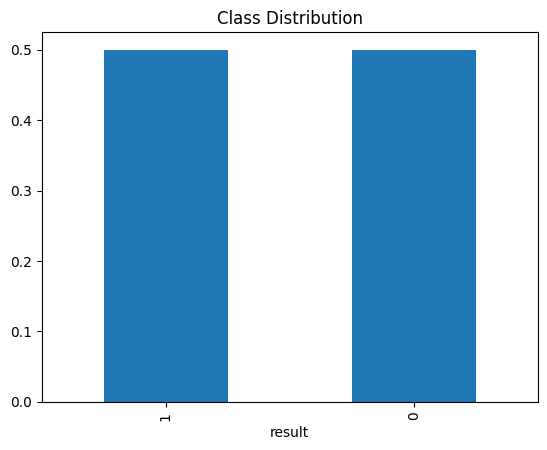

In [151]:
import matplotlib.pyplot as plt

class_counts = df['result'].value_counts()
display(class_counts)

df['result'].value_counts(normalize=True).plot(kind='bar', title='Class Distribution')
plt.show()

### Feature Distributions 

,result,team kpm,ckpm,firstdragon,dragons,opp_dragons,elders,opp_elders,firstherald,heralds,opp_heralds,void_grubs,opp_void_grubs,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,turretplates,opp_turretplates,inhibitors,opp_inhibitors,damagetochampions,dpm,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,goldspent,gspd,gpr,minionkills,monsterkills,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15,top_champ,jng_champ,mid_champ,bot_champ,sup_champ
count,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.00000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000
mean,0.500000,0.468891,0.937783,0.499885,2.253787,2.253787,0.055417,0.055417,0.499100,0.868106,0.868106,0.484422,0.484422,0.473835,0.687354,0.687354,0.500000,6.001852,6.001852,0.500000,0.499979,2.801055,2.801055,0.929570,0.929570,68941.399471,2157.128507,3050.388072,2830.234264,97.906198,3.054268,43.513444,1.343455,37.048941,233.882208,7.273826,56875.522347,36119.860500,1141.889257,52643.975080,0.000000,0.000000,804.497949,196.004969,31.638094,15703.146416,18347.378421,316.896782,15703.146416,18347.378421,316.896782,0.00000,0.000000,0.000000,2.181453,3.316768,2.190168,2.181453,3.316768,2.190168,24837.829700,29467.390212,503.232298,24837.829700,29467.390212,503.232298,0.000000,0.000000,0.000000,4.131152,6.873985,4.143392,4.131152,6.873985,4.143392,69.991505,99.486588,83.460673,78.333100,81.899648
std,0.500003,0.260068,0.314938,0.500003,1.399488,1.399488,0.243975,0.243975,0.500002,0.770605,0.770605,1.374989,1.374989,0.499318,0.736014,0.736014,0.500003,3.644028,3.644028,0.500003,0.500003,3.044764,3.044764,1.094443,1.094443,24967.498890,593.899971,593.914232,821.311270,32.296854,0.688913,17.520241,0.396701,12.933482,70.653898,1.288127,11391.109984,8630.324659,203.830479,10614.745388,0.146592,2.471405,149.738585,49.325251,2.663975,1003.006234,914.516700,25.243093,1003.006234,914.516700,25.243093,1525.28197,1092.509286,27.049014,1.953063,3.435286,1.958261,1.953063,3.435286,1.958261,1900.494791,1515.906052,38.302259,1900.494791,1515.906052,38.302259,3094.205022,2099.053247,41.646018,3.047304,5.547615,3.052965,3.047304,5.547615,3.052965,41.679492,43.559286,54.270436,53.210033,40.721417
min,0.000000,0.000000,0.084300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9873.000000,434.296200,1180.115900,797.301600,0.000000,0.000000,0.000000,0.000000,1.000000,27.000000,1.727100,20087.000000,9417.000000,554.655300,16980.000000,-0.590208,-11.070000,266.000000,42.000000,16.976400,12042.000000,12293.0000

Feature skewness: 


elders                      4.670458
opp_elders                  4.670458
opp_void_grubs              2.933926
void_grubs                  2.933926
assistsat10                 1.553874
opp_assistsat10             1.553874
opp_killsat10               1.253985
killsat10                   1.253985
opp_deathsat10              1.253688
deathsat10                  1.253688
opp_killsat15               1.228453
killsat15                   1.228453
deathsat15                  1.227992
opp_deathsat15              1.227992
opp_assistsat15             1.204475
assistsat15                 1.204475
inhibitors                  1.199537
opp_inhibitors              1.199537
damagemitigatedperminute    1.004933
damagetochampions           0.998454
opp_turretplates            0.908001
turretplates                0.908001
ckpm                        0.894474
team kpm                    0.831311
wardskilled                 0.799466
opp_barons                  0.789168
barons                      0.789168
o

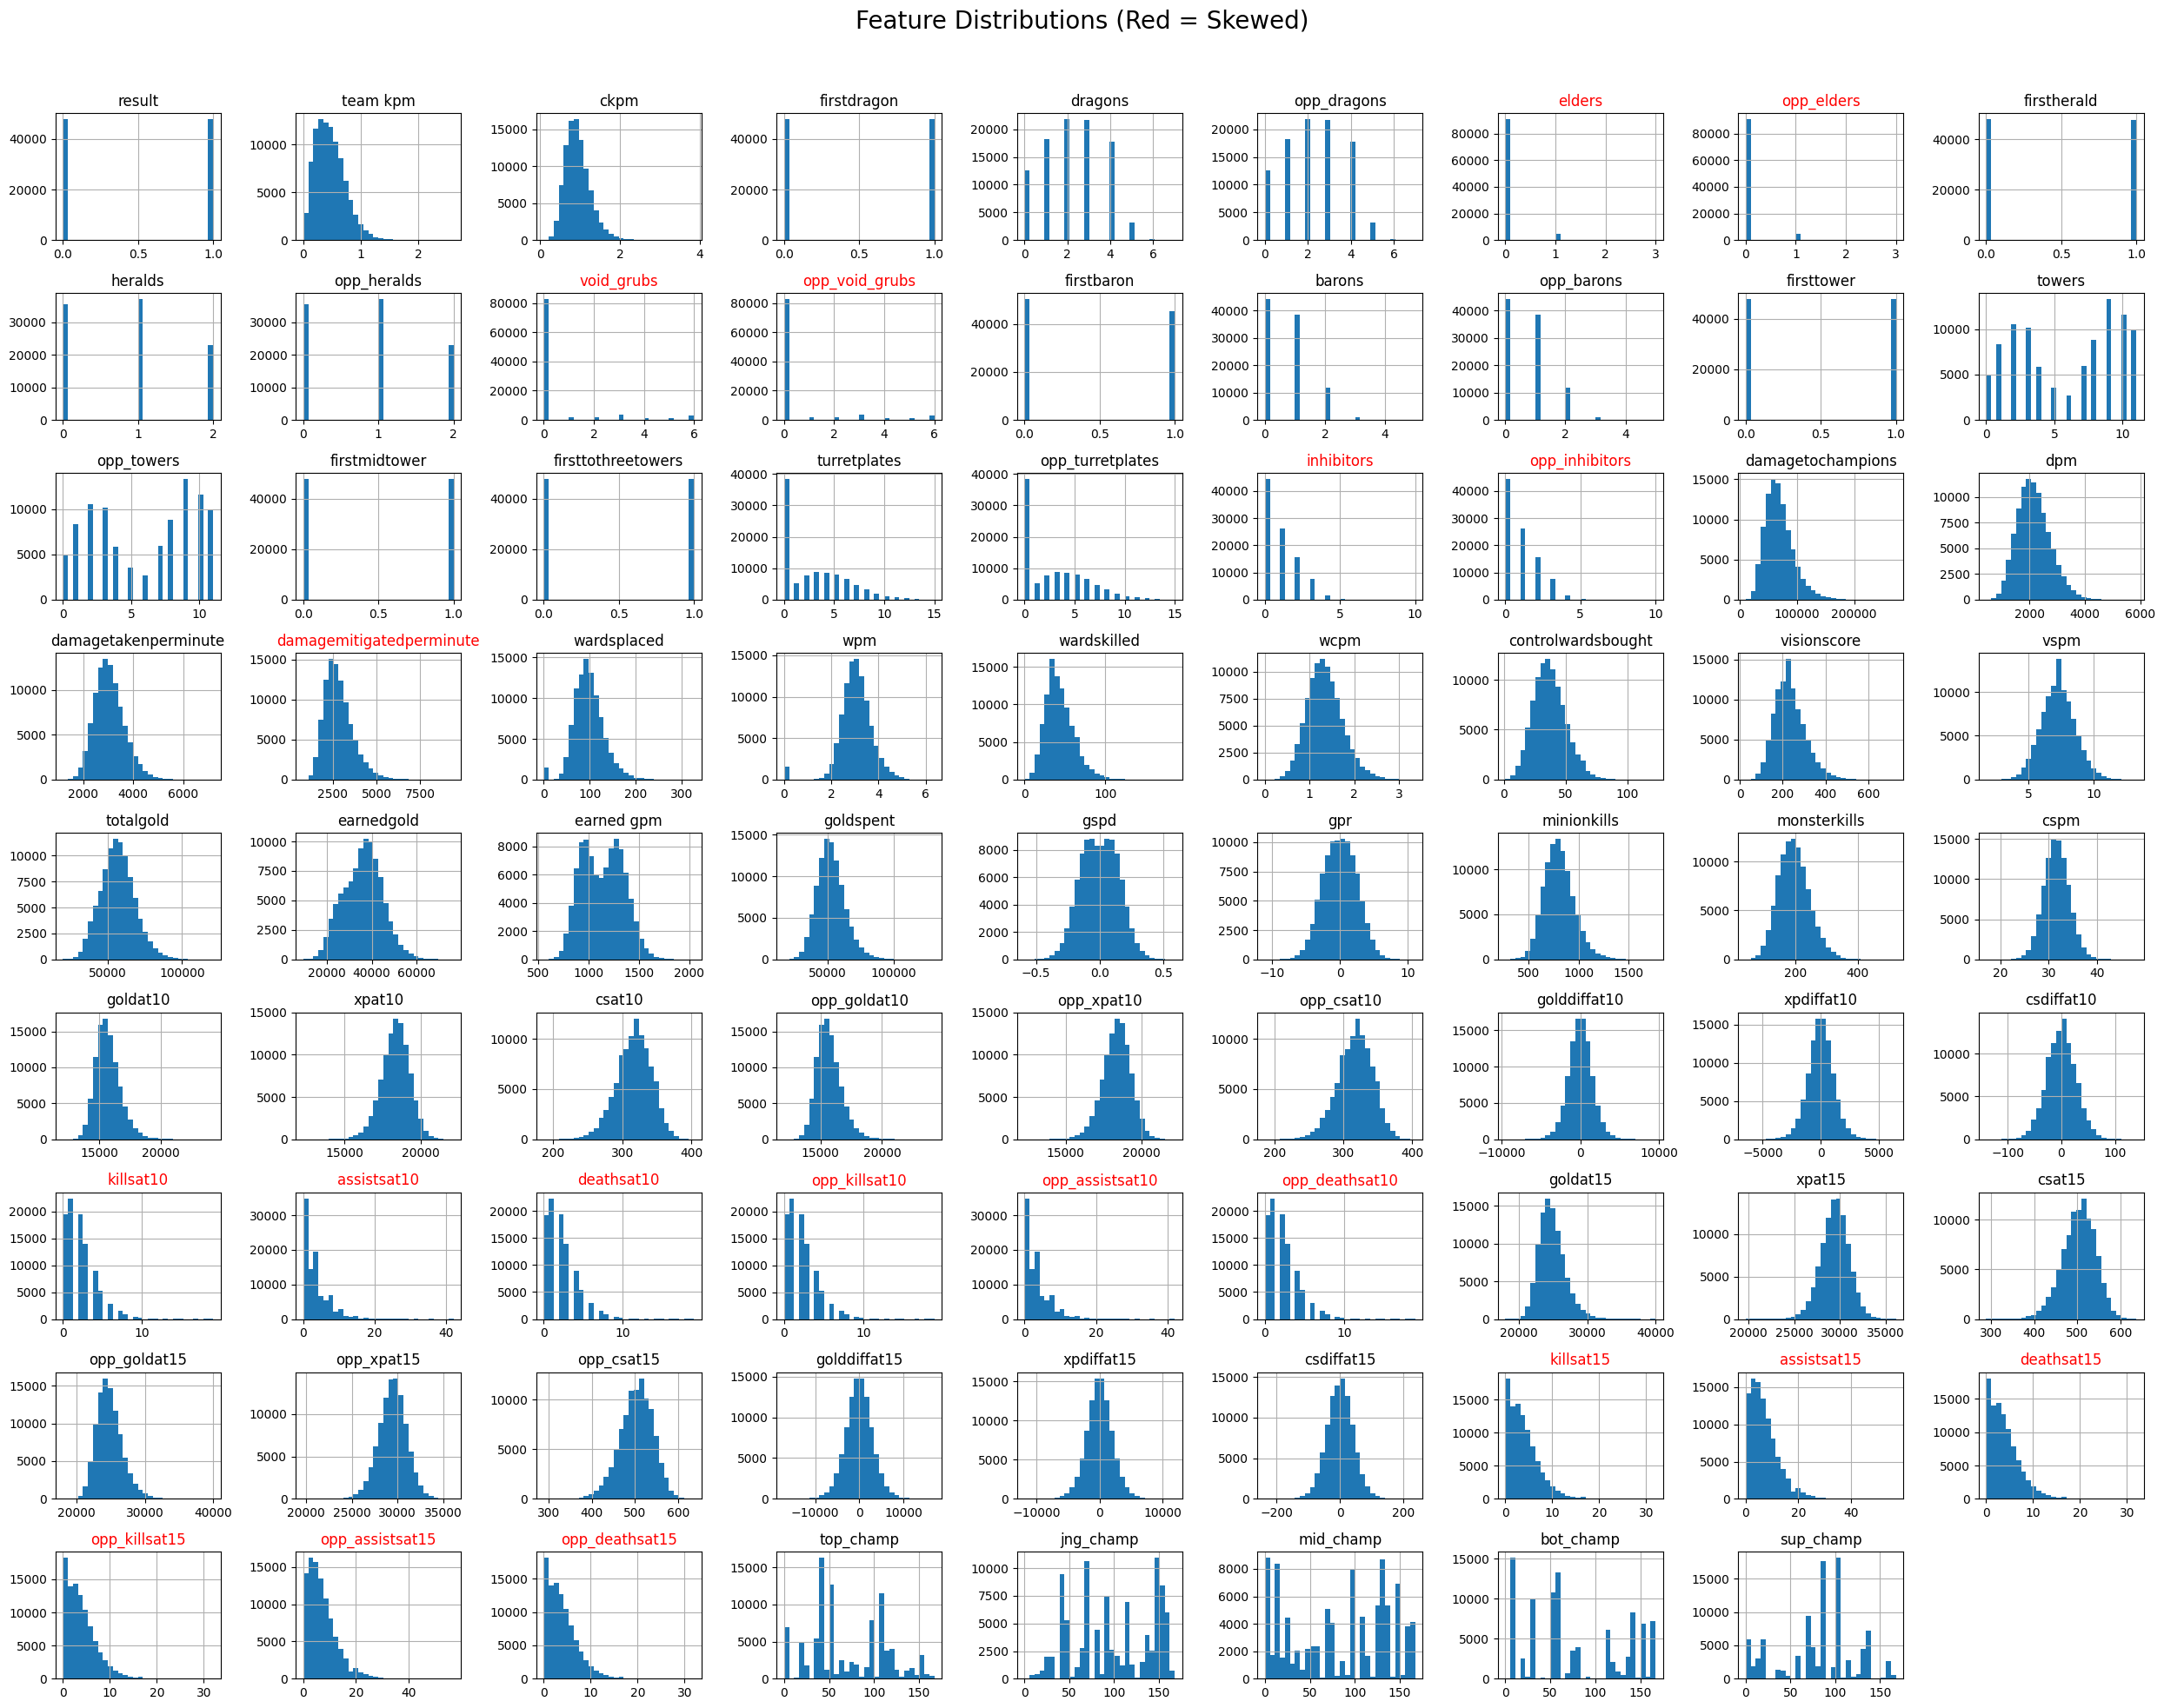

In [152]:
display(df.describe())
print("Feature skewness: ")
display(df.skew().sort_values(ascending=False))

skewed = df.skew()[abs(df.skew()) > 1].index
axes = df.hist(bins=30, figsize=(25, 20))

# Annotate skewed features
for ax in axes.flatten():
    if ax.get_title() in skewed:
        ax.set_title(ax.get_title(), color='red')

plt.suptitle("Feature Distributions (Red = Skewed)", fontsize=20)
plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()

#### Apply normalization to skew data

In [153]:
import numpy as np
import joblib
import json

# Compute skewed features
skewed_features = df.skew()[abs(df.skew()) >= 1].index.tolist()

# Apply log transform to skewed + non-negative features
for col in skewed_features:
    if (df[col] >= 0).all():
        df[col] = np.log1p(df[col])
        df.rename(columns={col: f"{col}_normalized"}, inplace=True)
    else:
        print(f"Feature {col} contains negative values, skip log transform")

# Define which columns to exclude from scaling
label_col = 'result'
binary_cols = [
    'firstdragon', 'firstherald', 'firstbaron', 'firsttower',
    'firstmidtower', 'firsttothreetowers'
]
categorical_cols = [
    'top_champ', 'jng_champ', 'mid_champ', 'bot_champ', 'sup_champ'
]
exclude_cols = [label_col] + binary_cols + categorical_cols
normalize_cols = df.columns.difference(exclude_cols)

# Fit and apply MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[normalize_cols] = scaler.fit_transform(df[normalize_cols])

# Save transformer and info
joblib.dump(scaler, "data/minmax_scaler.pkl")
with open("data/skewed_features.json", "w") as f:
    json.dump(skewed_features, f)
with open("data/normalize_cols.json", "w") as f:
    json.dump(list(normalize_cols), f)


#### Feature Distribution after normalization

,result,team kpm,ckpm,firstdragon,dragons,opp_dragons,elders_normalized,opp_elders_normalized,firstherald,heralds,opp_heralds,void_grubs_normalized,opp_void_grubs_normalized,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,turretplates,opp_turretplates,inhibitors_normalized,opp_inhibitors_normalized,damagetochampions,dpm,damagetakenperminute,damagemitigatedperminute_normalized,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,goldspent,gspd,gpr,minionkills,monsterkills,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10_normalized,assistsat10_normalized,deathsat10_normalized,opp_killsat10_normalized,opp_assistsat10_normalized,opp_deathsat10_normalized,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15_normalized,assistsat15_normalized,deathsat15_normalized,opp_killsat15_normalized,opp_assistsat15_normalized,opp_deathsat15_normalized,top_champ,jng_champ,mid_champ,bot_champ,sup_champ
count,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000,95584.000000
mean,0.500000,0.179254,0.226352,0.499885,0.321970,0.321970,0.026983,0.026983,0.499100,0.434053,0.434053,0.100432,0.100432,0.473835,0.137471,0.137471,0.500000,0.545623,0.545623,0.500000,0.499979,0.186737,0.186737,0.214077,0.214077,0.224307,0.318184,0.310558,0.497113,0.300326,0.479304,0.233943,0.400135,0.295483,0.294285,0.480727,0.365027,0.398122,0.393102,0.313282,0.500000,0.500000,0.358044,0.320844,0.468970,0.299897,0.613723,0.600444,0.299897,0.613723,0.600444,0.500000,0.500000,0.500000,0.323991,0.306608,0.324883,0.323991,0.306608,0.324883,0.311282,0.594622,0.617384,0.311282,0.594622,0.617384,0.500000,0.500000,0.500000,0.414414,0.438005,0.415138,0.414414,0.438005,0.415138,69.991505,99.486588,83.460673,78.333100,81.899648
std,0.500003,0.099422,0.083525,0.500003,0.199927,0.199927,0.116468,0.116468,0.500002,0.385302,0.385302,0.265357,0.265357,0.499318,0.147203,0.147203,0.500003,0.331275,0.331275,0.500003,0.500003,0.202984,0.202984,0.219291,0.219291,0.094812,0.109685,0.098619,0.113471,0.099070,0.108111,0.094195,0.118154,0.106012,0.100503,0.111640,0.113026,0.128673,0.136447,0.093243,0.124187,0.111626,0.099560,0.102761,0.085210,0.082160,0.092703,0.115794,0.082160,0.092703,0.115794,0.079766,0.084507,0.096604,0.209212,0.215607,0.209292,0.209212,0.215607,0.209292,0.086555,0.092220,0.110381,0.086555,0.092220,0.110381,0.090707,0.088092,0.087861,0.184523,0.203162,0.184473,0.184523,0.203162,0.184473,41.679492,43.559286,54.270436,53.210033,40.721417
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

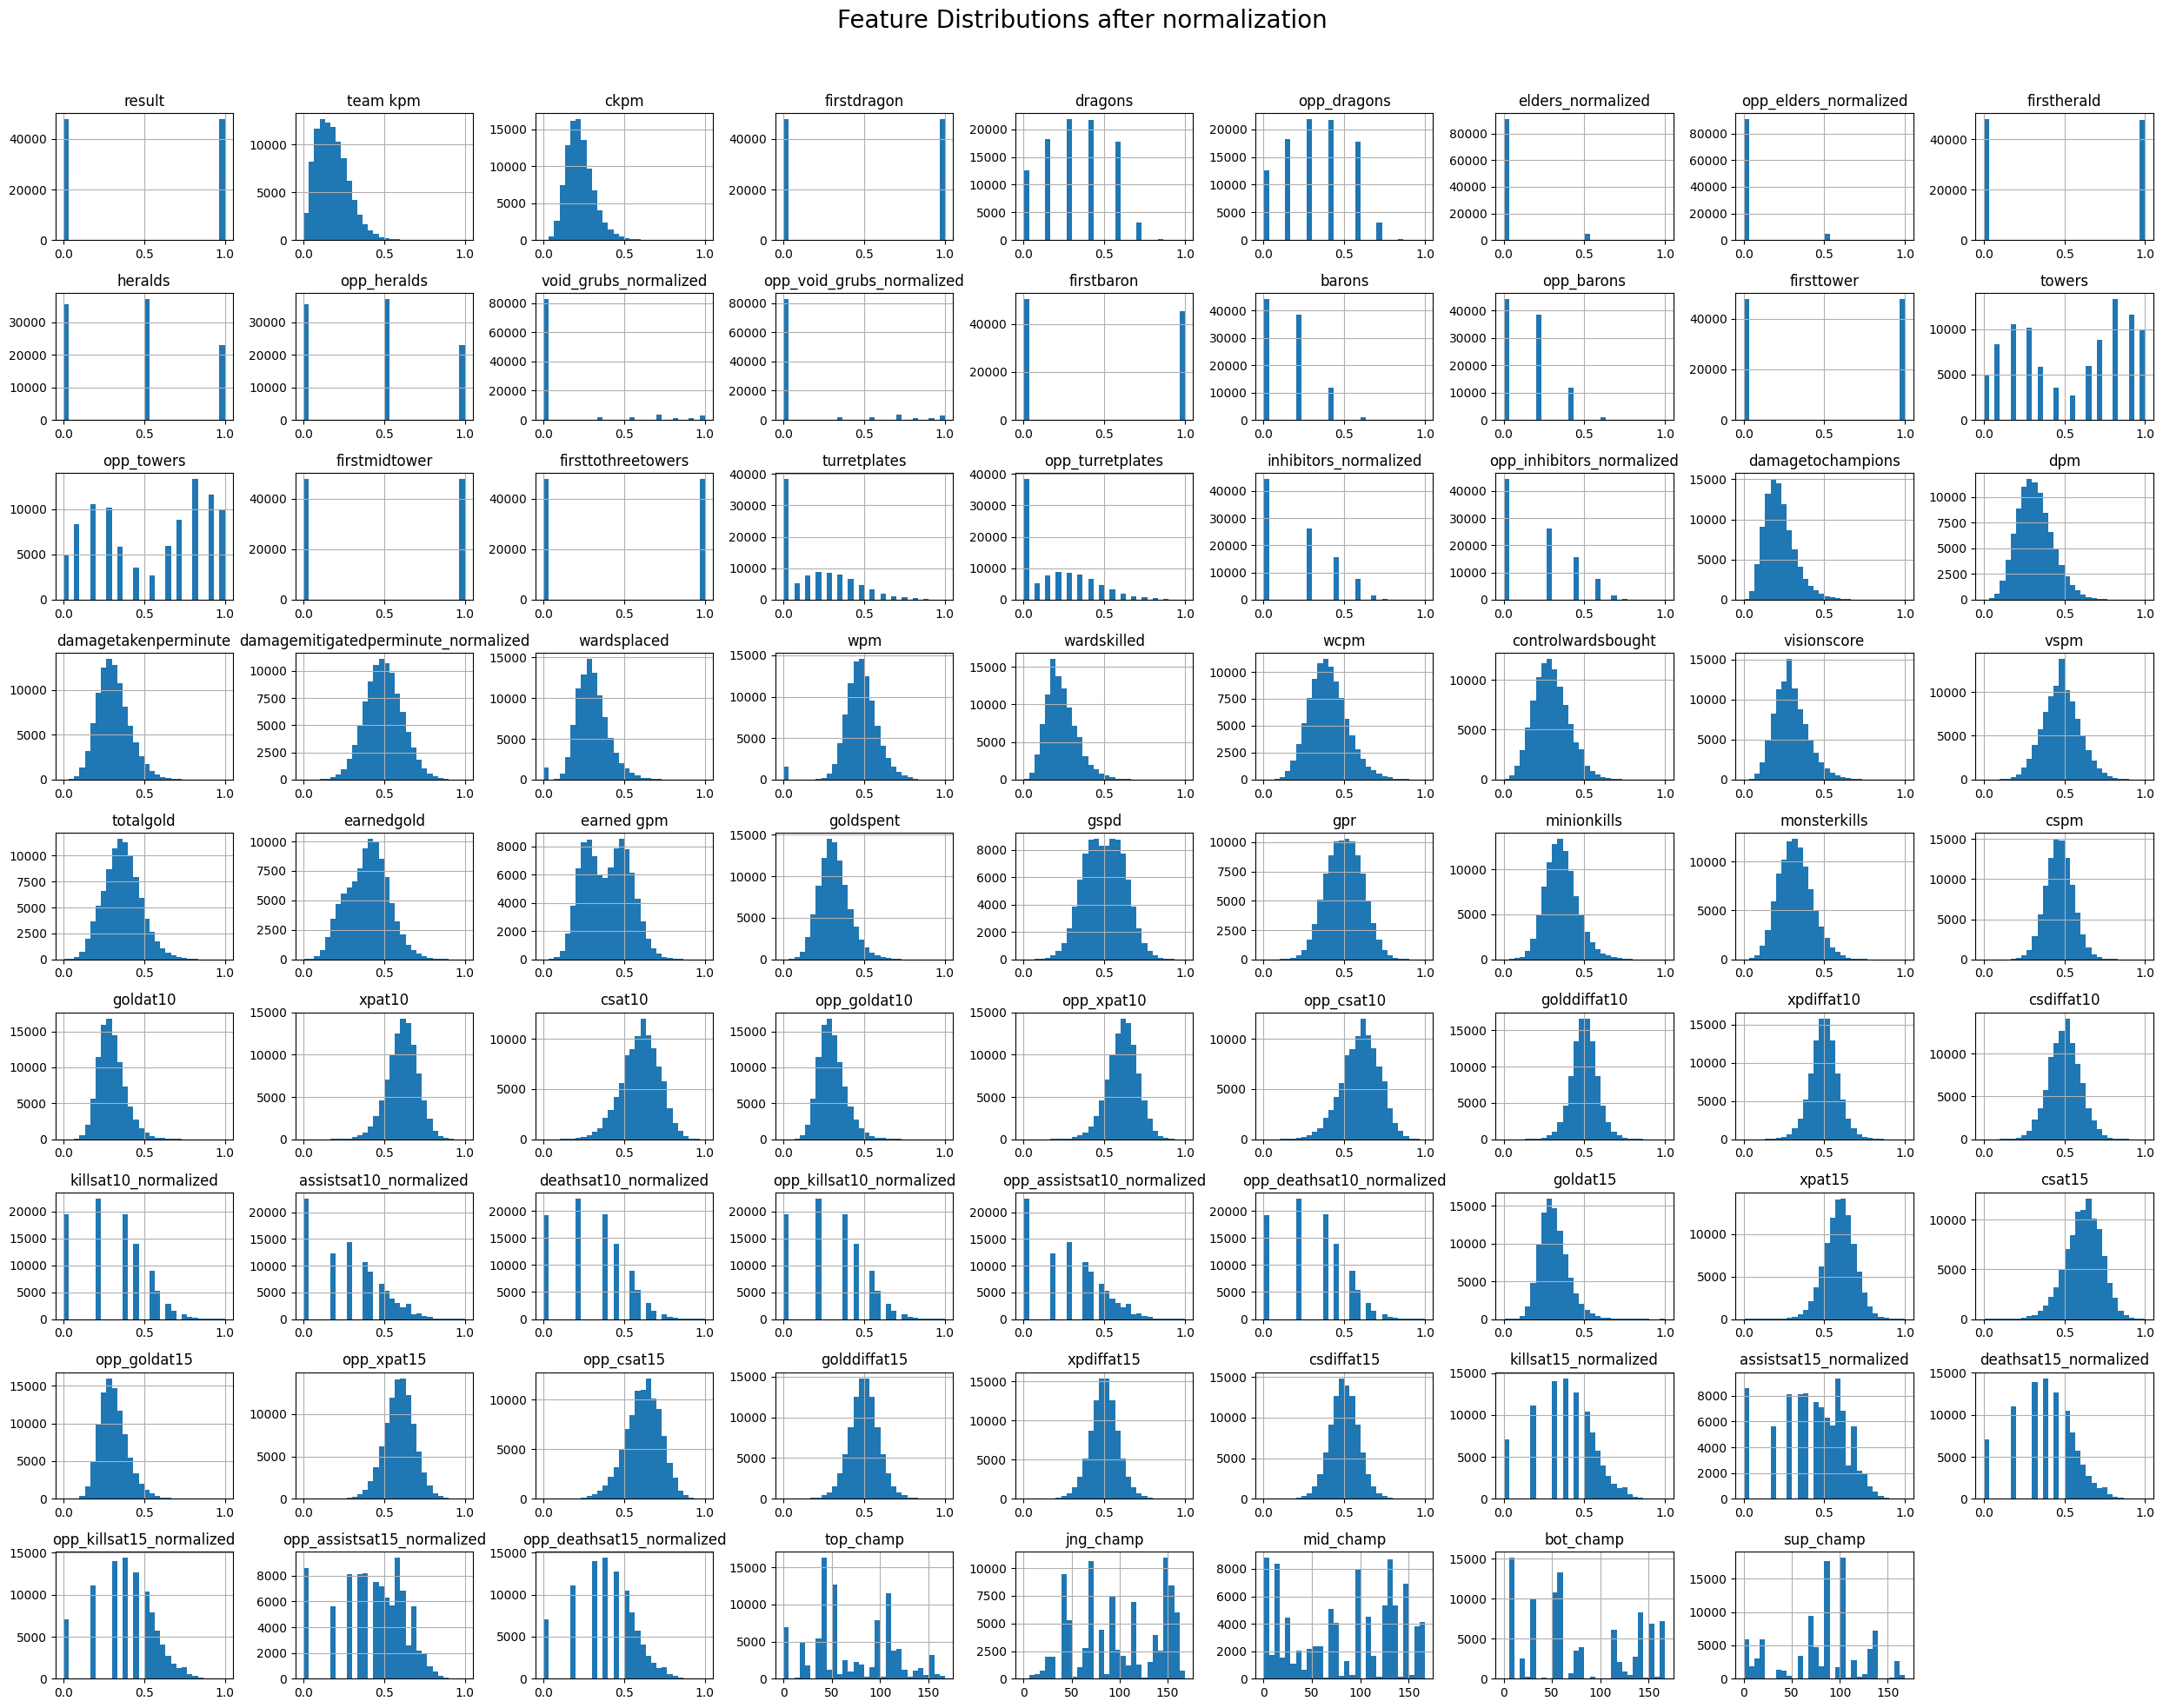

In [154]:
display(df.describe())

axes = df.hist(bins=30, figsize=(25, 20))

plt.suptitle("Feature Distributions after normalization", fontsize=20)
plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()

### Correlation with Target

,team kpm,ckpm,firstdragon,dragons,opp_dragons,elders_normalized,opp_elders_normalized,firstherald,heralds,opp_heralds,void_grubs_normalized,opp_void_grubs_normalized,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,turretplates,opp_turretplates,inhibitors_normalized,opp_inhibitors_normalized,damagetochampions,dpm,damagetakenperminute,damagemitigatedperminute_normalized,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,goldspent,gspd,gpr,minionkills,monsterkills,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10_normalized,assistsat10_normalized,deathsat10_normalized,opp_killsat10_normalized,opp_assistsat10_normalized,opp_deathsat10_normalized,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15_normalized,assistsat15_normalized,deathsat15_normalized,opp_killsat15_normalized,opp_assistsat15_normalized,opp_deathsat15_normalized,top_champ,jng_champ,mid_champ,bot_champ,sup_champ
result,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.112850,0.226352,0.412287,0.204272,0.439667,0.010120,0.043846,0.400611,0.327032,0.541074,0.091089,0.109774,0.143225,0.045016,0.229926,0.313065,0.252460,0.838786,0.268706,0.219828,0.151105,0.222369,0.026753,0.401401,0.196972,0.273324,0.331971,0.493336,0.294709,0.469302,0.222744,0.379792,0.291571,0.275971,0.443554,0.315853,0.324233,0.281040,0.290015,0.406184,0.42136,0.351196,0.286025,0.439015,0.271702,0.591383,0.579362,0.328092,0.636063,0.621526,0.463999,0.465906,0.467173,0.281481,0.266887,0.367225,0.366501,0.346328,0.282542,0.272876,0.562672,0.592480,0.349689,0.626572,0.642288,0.450557,0.455918,0.463537,0.365959,0.389285,0.463435,0.462870,0.486725,0.366842,70.357194,99.714848,83.448862,78.622154,81.729285
1,0.245657,0.226352,0.587483,0.439667,0.204272,0.043846,0.010120,0.597590,0.541074,0.327032,0.109774,0.091089,0.804444,0.229926,0.045016,0.686935,0.838786,0.252460,0.731294,0.780131,0.222369,0.151105,0.401401,0.026753,0.251642,0.363044,0.289145,0.500890,0.305943,0.489305,0.245142,0.420478,0.299396,0.312598,0.517900,0.414201,0.472012,0.505165,0.336548,0.593816,0.57864,0.364892,0.355662,0.498925,0.328092,0.636063,0.621526,0.271702,0.591383,0.579362,0.536001,0.534094,0.532827,0.366501,0.346328,0.282542,0.281481,0.266887,0.367225,0.349689,0.626572,0.642288,0.272876,0.562672,0.592480,0.549443,0.544082,0.536463,0.462870,0.486725,0.366842,0.365959,0.389285,0.463435,69.625816,99.258328,83.472485,78.044045,82.070012


<Axes: title={'center': 'Feature Mean by Result'}>

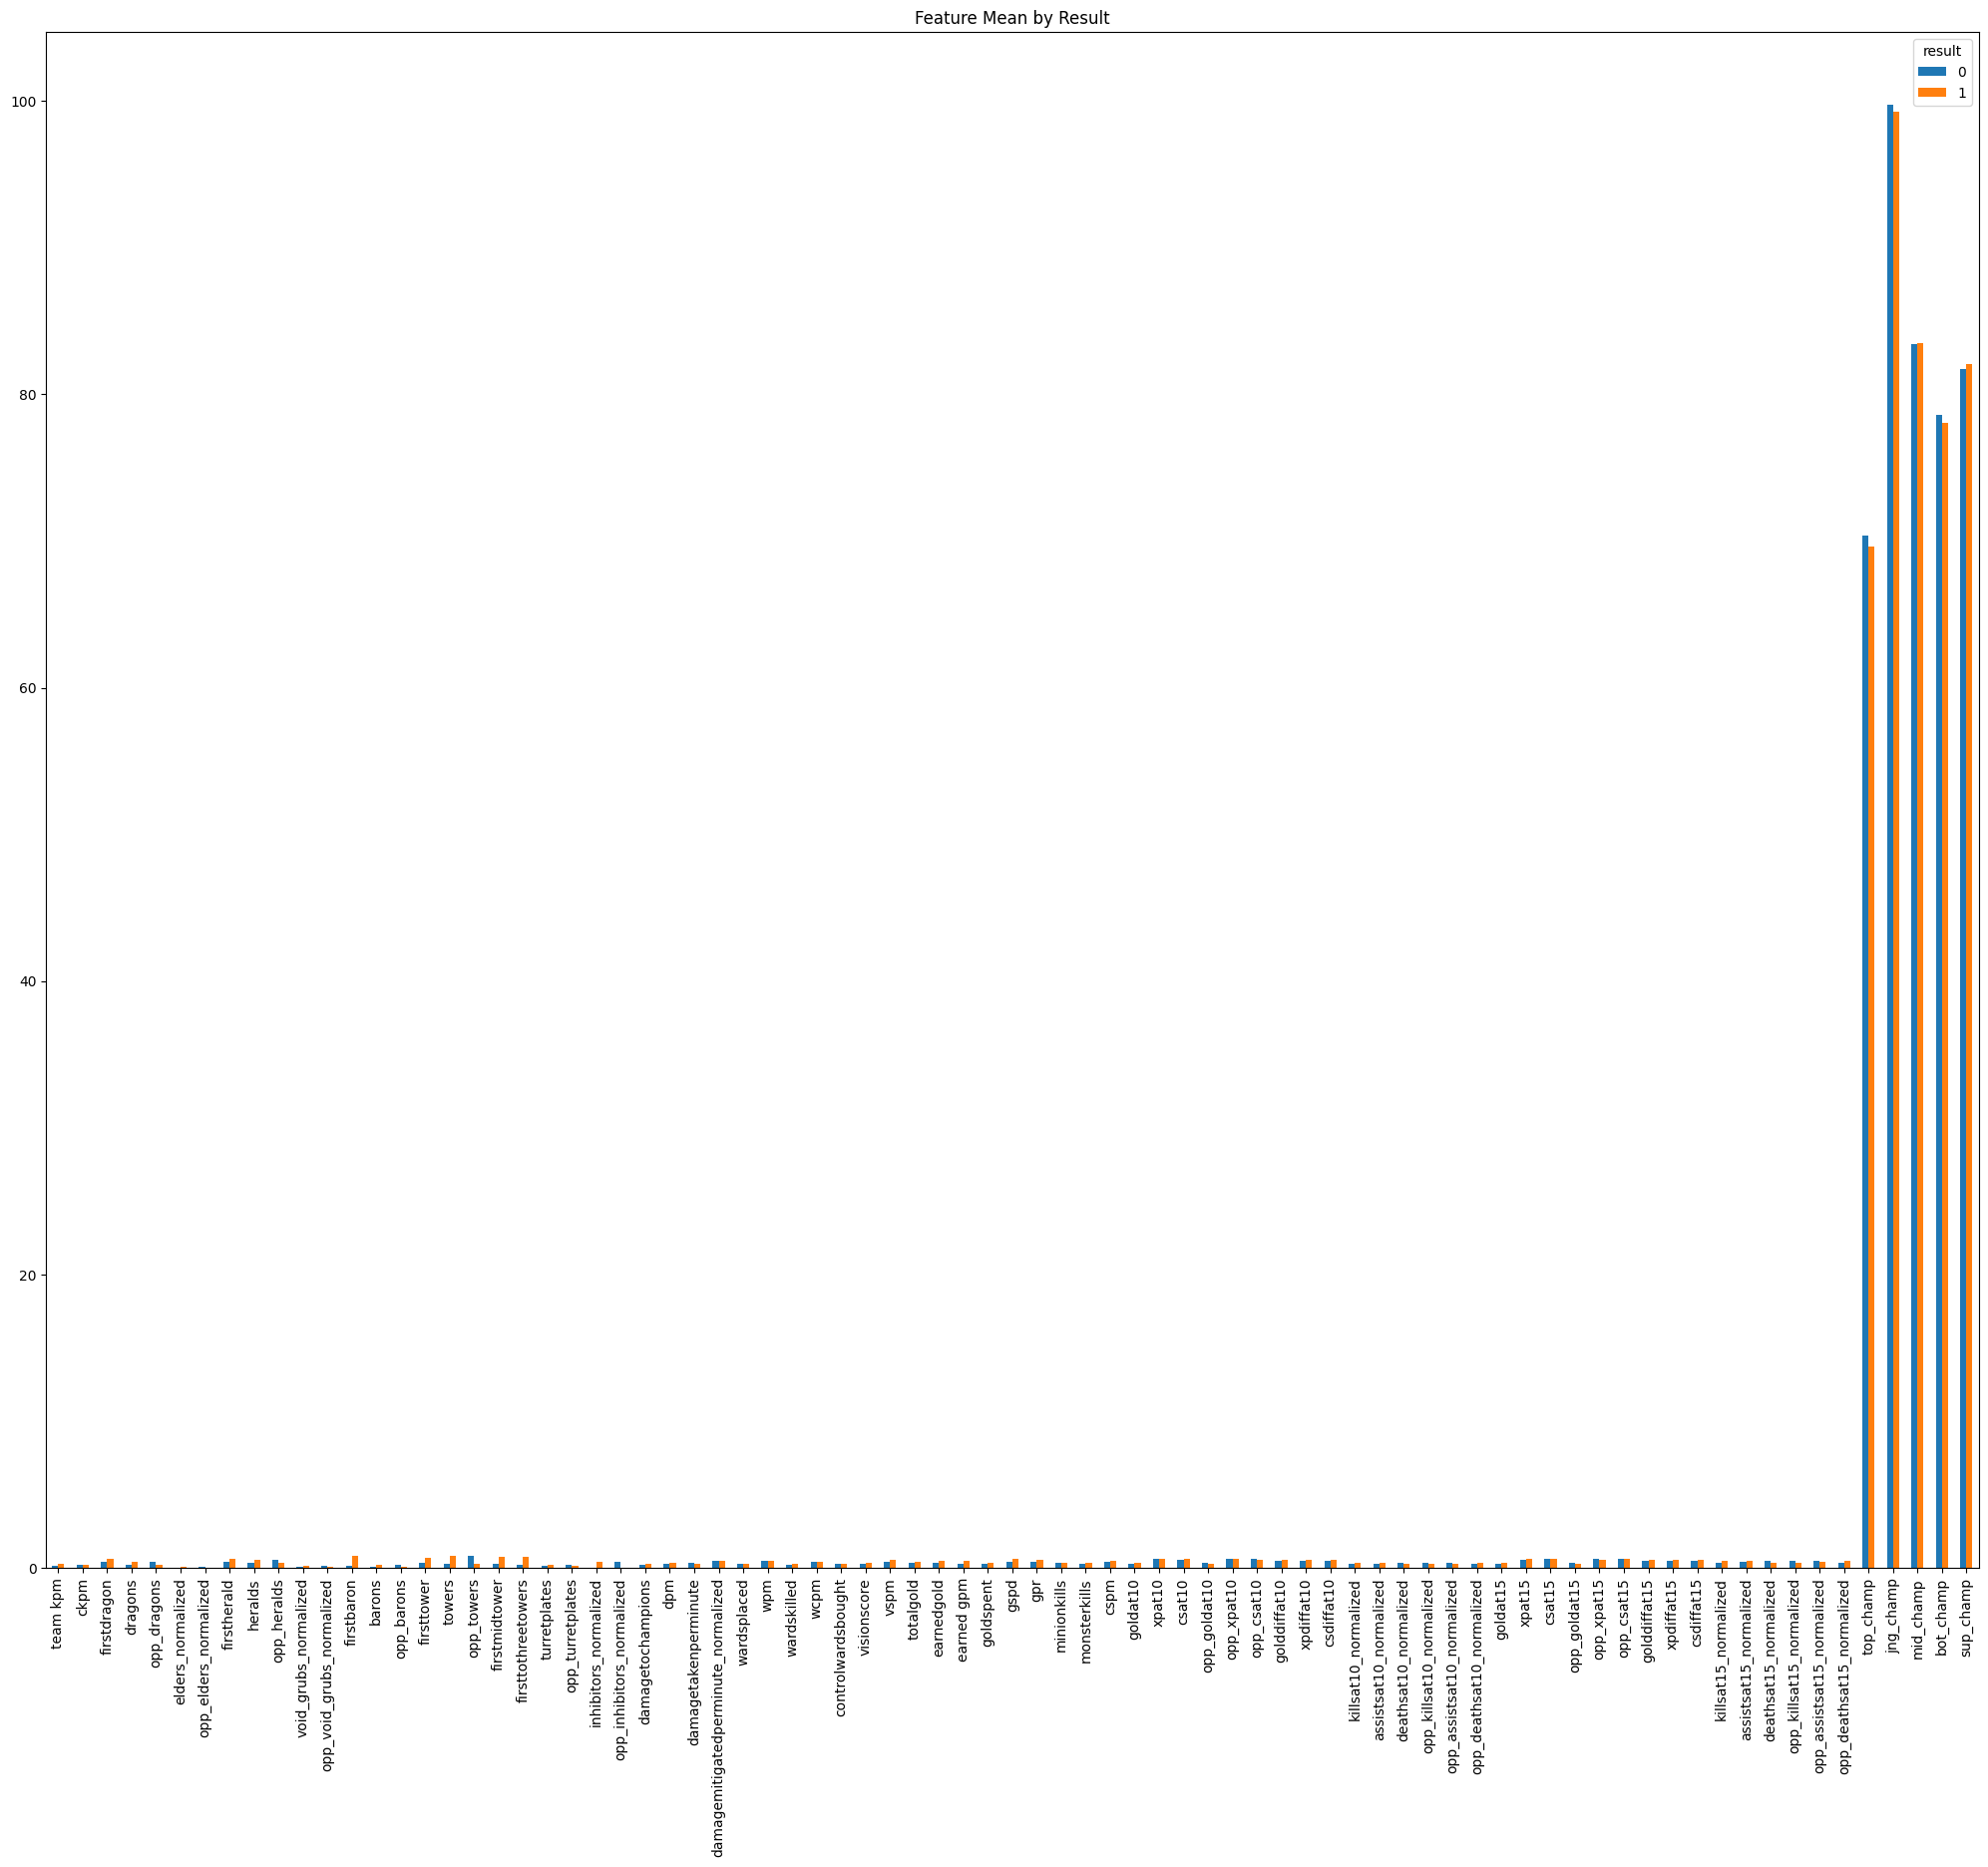

In [155]:
grouped_means = df.groupby('result').mean()
display(grouped_means)

df.groupby('result').mean().T.plot(kind='bar', figsize=(25, 20), title='Feature Mean by Result')


### Feature Correlation Matrix / Heatmap

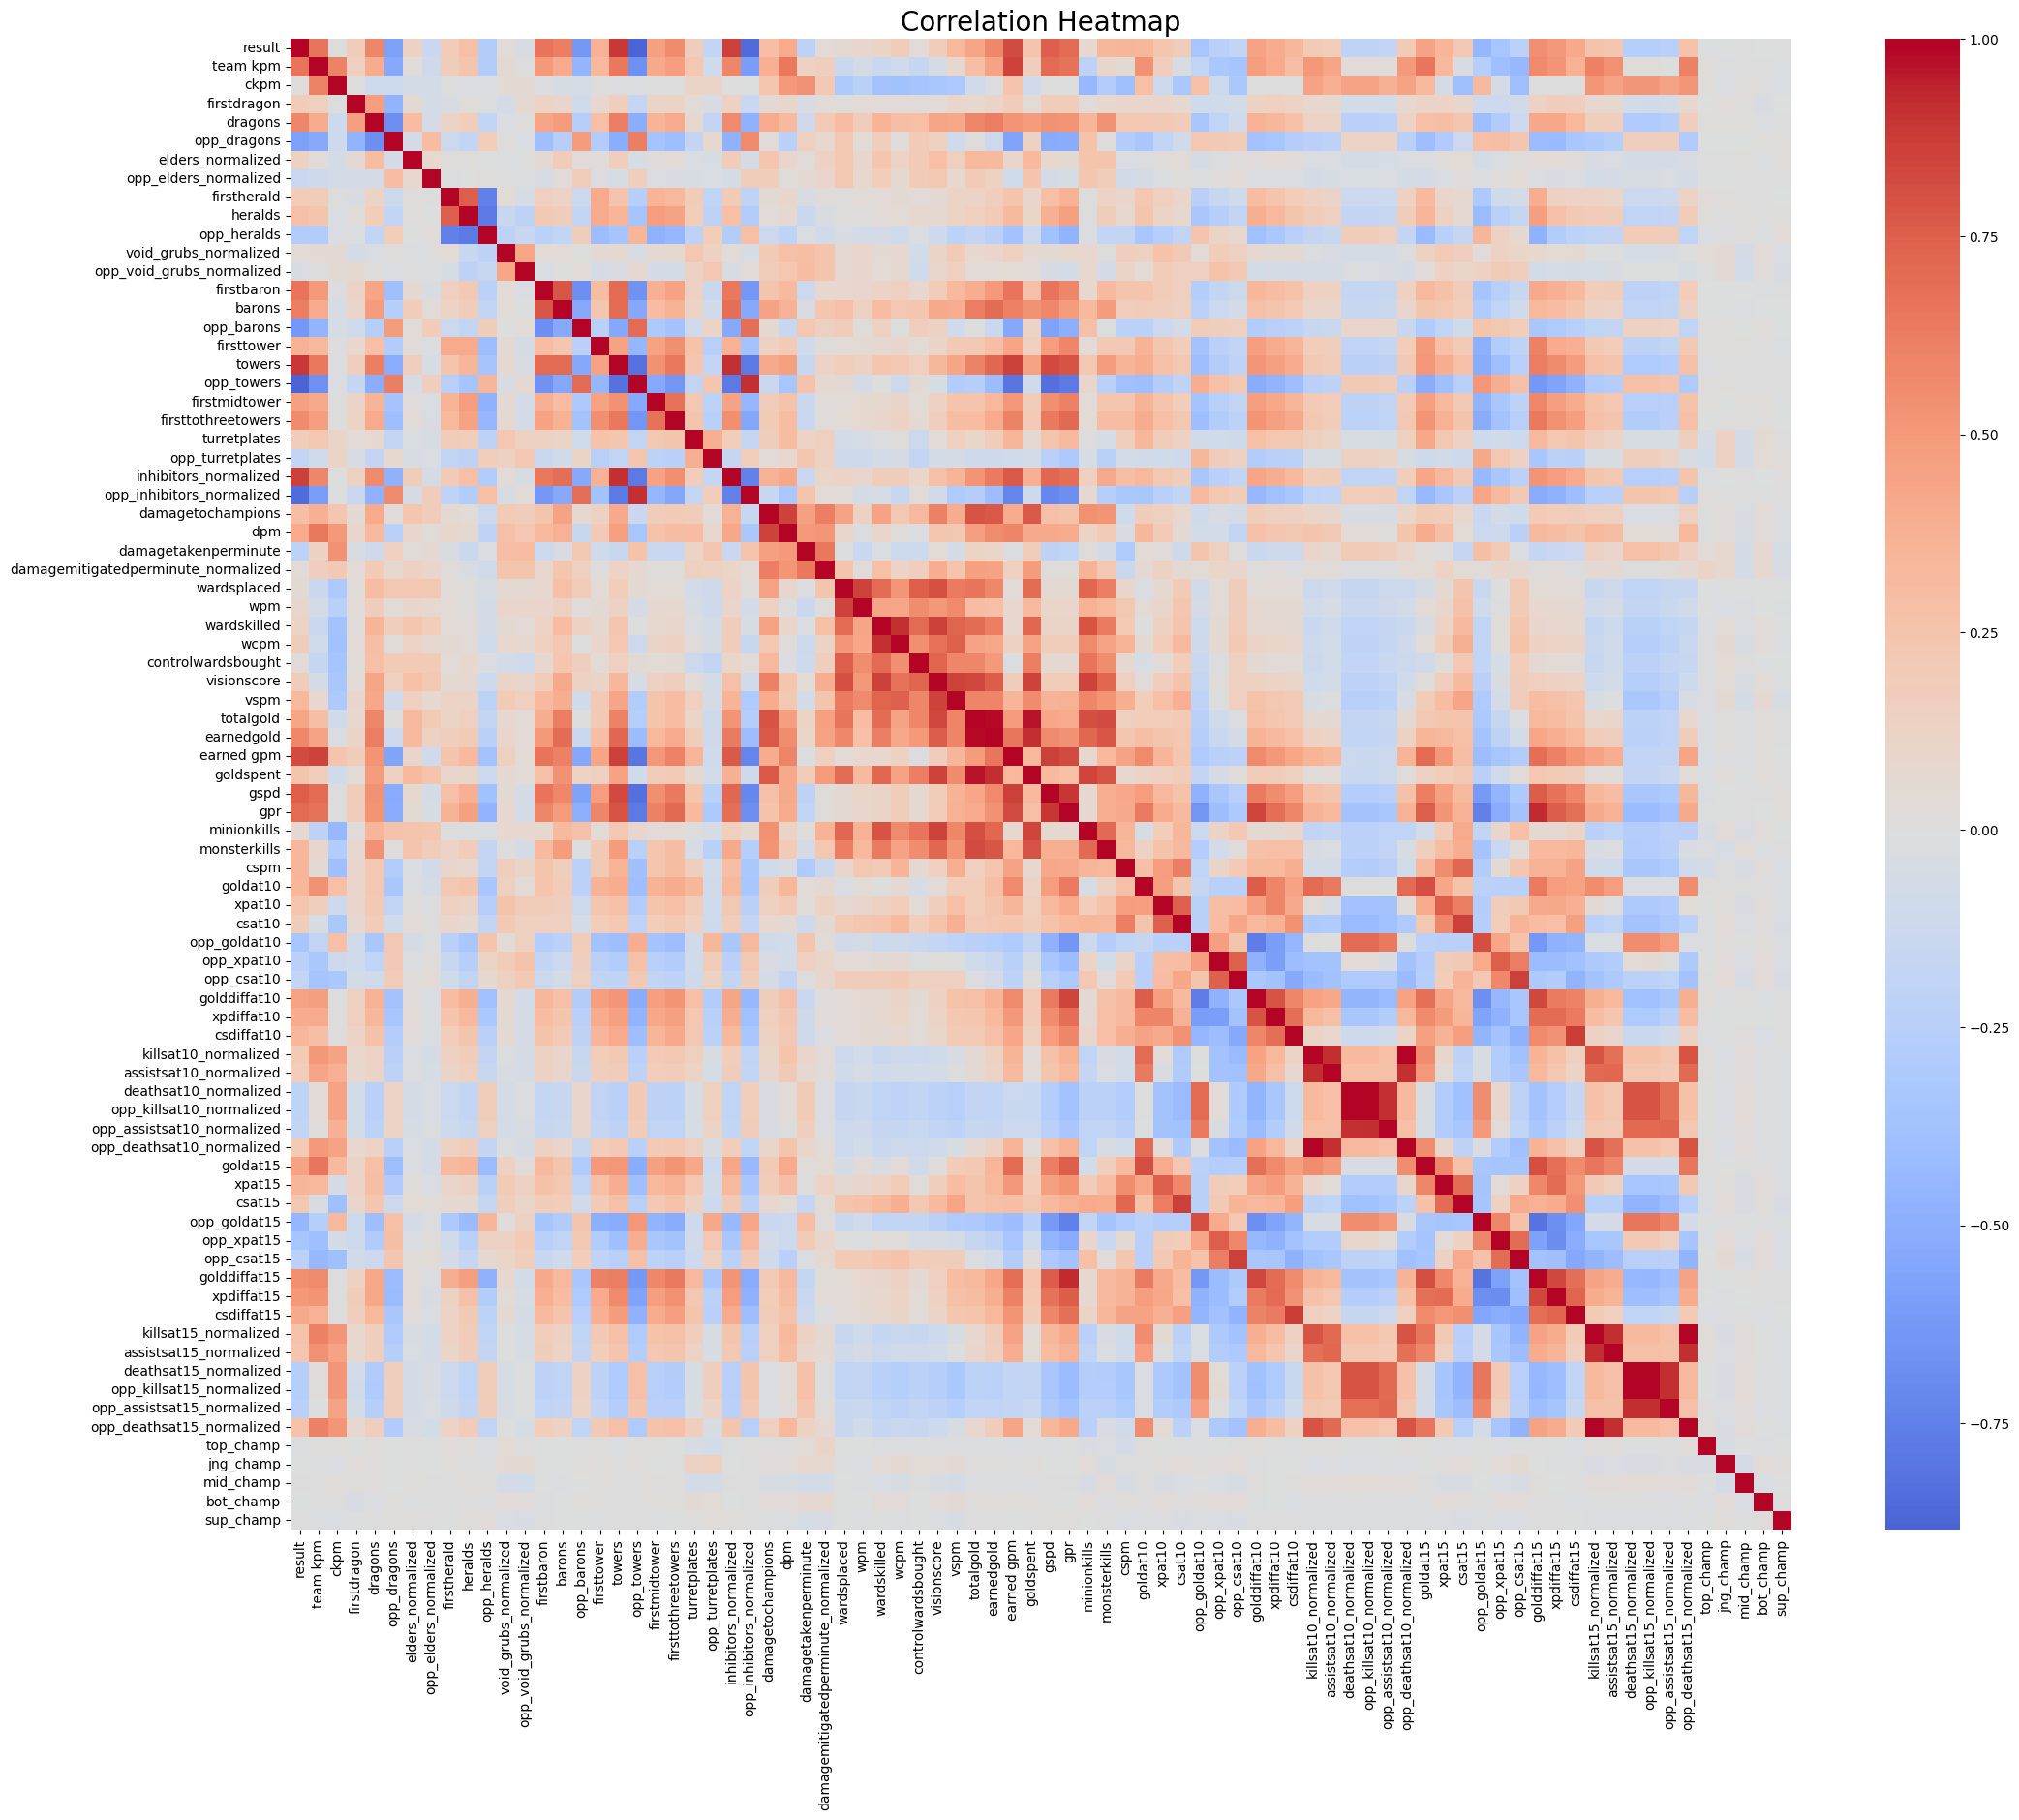

In [157]:
import seaborn as sns

# correlation_matrix = df.corr()
# display(correlation_matrix)

plt.figure(figsize=(25, 20))
sns.heatmap(df.corr(), cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Heatmap', fontsize=20)
plt.show()

## Save the processed data to Parquet

In [159]:
df.to_parquet("data/processed_lol_data.parquet", index=False)

# Model Training


## Define Numerical Columns

In [ ]:
is_numerical = [
    True,  # team kpm
    True,  # ckpm
    False, # firstdragon
    True,  # dragons
    True,  # opp_dragons
    True,  # elders_normalized
    True,  # opp_elders_normalized
    False, # firstherald
    True,  # heralds
    True,  # opp_heralds
    True,  # void_grubs_normalized
    True,  # opp_void_grubs_normalized
    False, # firstbaron
    True,  # barons
    True,  # opp_barons
    False, # firsttower
    True,  # towers
    True,  # opp_towers
    False, # firstmidtower
    False, # firsttothreetowers
    True,  # turretplates
    True,  # opp_turretplates
    True,  # inhibitors_normalized
    True,  # opp_inhibitors_normalized
    True,  # damagetochampions
    True,  # dpm
    True,  # damagetakenperminute
    True,  # damagemitigatedperminute_normalized
    True,  # wardsplaced
    True,  # wpm
    True,  # wardskilled
    True,  # wcpm
    True,  # controlwardsbought
    True,  # visionscore
    True,  # vspm
    True,  # totalgold
    True,  # earnedgold
    True,  # earned gpm
    True,  # goldspent
    True,  # gspd
    True,  # gpr
    True,  # minionkills
    True,  # monsterkills
    True,  # cspm
    True,  # goldat10
    True,  # xpat10
    True,  # csat10
    True,  # opp_goldat10
    True,  # opp_xpat10
    True,  # opp_csat10
    True,  # golddiffat10
    True,  # xpdiffat10
    True,  # csdiffat10
    True,  # killsat10_normalized
    True,  # assistsat10_normalized
    True,  # deathsat10_normalized
    True,  # opp_killsat10_normalized
    True,  # opp_assistsat10_normalized
    True,  # opp_deathsat10_normalized
    True,  # goldat15
    True,  # xpat15
    True,  # csat15
    True,  # opp_goldat15
    True,  # opp_xpat15
    True,  # opp_csat15
    True,  # golddiffat15
    True,  # xpdiffat15
    True,  # csdiffat15
    True,  # killsat15_normalized
    True,  # assistsat15_normalized
    True,  # deathsat15_normalized
    True,  # opp_killsat15_normalized
    True,  # opp_assistsat15_normalized
    True,  # opp_deathsat15_normalized
    False, # top_champ
    False, # jng_champ
    False, # mid_champ
    False, # bot_champ
    False  # sup_champ
]

## Load Processed data

In [ ]:
import pandas as pd
import os

df = pd.read_parquet("data/processed_lol_data.parquet")

In [ ]:
import torch
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")

## Define data loader

In [ ]:
def create_dataloaders(df, batch_size=64, test_size=0.2, seed=42):
    from sklearn.model_selection import train_test_split
    from torch.utils.data import Dataset, DataLoader
    import torch

    class LoLDataset(torch.utils.data.Dataset):
        def __init__(self, df):
            self.X = torch.tensor(df.drop(columns=['result']).values, dtype=torch.float32)
            self.y = torch.tensor(df['result'].values, dtype=torch.long)

        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    train_df, test_df = train_test_split(df, test_size=test_size, random_state=seed, stratify=df['result'])

    train_dataset = LoLDataset(train_df)
    test_dataset = LoLDataset(test_df)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


## Define DNN Model

In [ ]:
import torch.nn as nn

from lolnet import LoLNet


## Define Training Loop

In [ ]:
import torch
from sklearn.metrics import accuracy_score
import numpy as np
from trades import trades_loss
from jacobian import JacobianReg


def add_input_noise(x, sigma=0.01, is_numerical=None):
    noise = torch.randn_like(x) * sigma
    if is_numerical is not None:
        mask = torch.tensor(is_numerical, dtype=torch.float32, device=x.device)
        noise *= mask
    return torch.clamp(x + noise, 0.0, 1.0)


def generate_pgd_adversarial(model, x, y, epsilon=0.02, alpha=0.002, steps=10, is_numerical=None):
    x_adv = x.clone().detach().requires_grad_(True)
    mask = torch.tensor(is_numerical, dtype=torch.float32, device=x.device)

    for _ in range(steps):
        output = model(x_adv)
        loss = torch.nn.CrossEntropyLoss()(output, y)
        grad = torch.autograd.grad(loss, x_adv, retain_graph=False, create_graph=False)[0]
        x_adv = x_adv + alpha * grad.sign() * mask
        x_adv = torch.min(torch.max(x_adv, x - epsilon), x + epsilon)
        x_adv = torch.clamp(x_adv, 0.0, 1.0).detach().requires_grad_(True)

    return x_adv.detach()


def train_model_with_perturbation(
    model, train_loader, test_loader, criterion, optimizer,
    num_epochs=10, device='cpu', patience=3,
    pgd=False, noise=False, trades=False, jacobian_reg=False,
    is_numerical=None, pgd_config=None, noise_sigma=0.01, lambda_JR=0.01
):
    if pgd_config is None:
        pgd_config = {'epsilon': 0.02, 'alpha': 0.002, 'steps': 10}

    print("🔧 Training Configuration:")
    print(f"📌 Device       : {device}")
    print(f"📌 Epochs       : {num_epochs}")
    print(f"📌 Patience     : {patience}")
    print(f"📌 PGD          : {pgd}")
    if pgd:
        print(f"   ↳ epsilon    : {pgd_config['epsilon']}")
        print(f"   ↳ alpha      : {pgd_config['alpha']}")
        print(f"   ↳ steps      : {pgd_config['steps']}")
    print(f"📌 Noise        : {noise}")
    if noise:
        print(f"   ↳ sigma      : {noise_sigma}")
    print(f"📌 TRADES       : {trades}")
    print(f"📌 Jacobian Reg : {jacobian_reg}")
    print(f"📌 Numerical Mask Present: {is_numerical is not None}")
    print("-" * 40)

    device = torch.device(device)
    model.to(device)
    best_acc, best_epoch = 0, -1
    best_model_state = None
    epoch_log = []
    reg = JacobianReg(n=1) if jacobian_reg else None

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        all_preds, all_labels = [], []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            X_clean = X_batch
            X_aug, y_aug = [], []

            if pgd:
                X_pgd = generate_pgd_adversarial(model, X_clean, y_batch, **pgd_config, is_numerical=is_numerical)
                X_aug.append(X_pgd)
                y_aug.append(y_batch)

            if noise:
                X_noisy = add_input_noise(X_clean, sigma=noise_sigma, is_numerical=is_numerical)
                X_aug.append(X_noisy)
                y_aug.append(y_batch)

            if X_aug:
                X_batch = torch.cat([X_clean] + X_aug, dim=0)
                y_batch = torch.cat([y_batch] + y_aug, dim=0)

            X_batch.requires_grad = True
            optimizer.zero_grad()

            if trades:
                loss = trades_loss(
                    model=model,
                    x_natural=X_clean,
                    y=y_batch[:len(X_clean)],
                    optimizer=optimizer,
                    step_size=pgd_config['alpha'],
                    epsilon=pgd_config['epsilon'],
                    perturb_steps=pgd_config['steps'],
                    distance='l_inf',
                    is_numerical=is_numerical
                )
            else:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                if jacobian_reg and reg is not None:
                    R = reg(X_batch, outputs)
                    loss += lambda_JR * R

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            with torch.no_grad():
                preds = model(X_batch).argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        avg_loss = total_loss / len(train_loader)

        # Evaluation
        model.eval()
        test_preds, test_labels = [], []
        with torch.no_grad():
            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device), y_test.to(device)
                preds = model(X_test).argmax(dim=1)
                test_preds.extend(preds.cpu().numpy())
                test_labels.extend(y_test.cpu().numpy())

        test_acc = accuracy_score(test_labels, test_preds)

        print(f"🧪 Epoch {epoch+1:>2}/{num_epochs:<2} | "
              f"Loss: {avg_loss:10.4f} | "
              f"Train Acc: {train_acc:7.4f} | "
              f"Test Acc: {test_acc:7.4f}")

        epoch_log.append({
            'epoch': epoch + 1,
            'train_acc': train_acc,
            'test_acc': test_acc,
            'loss': avg_loss
        })

        if test_acc > best_acc:
            best_acc = test_acc
            best_epoch = epoch
            best_model_state = model.state_dict()
        elif epoch - best_epoch >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, best_acc, epoch_log


In [ ]:
!pip show jacobian

## Define Training Function

In [ ]:
import os
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score

def train_lolnet_model(df, 
                       model_name, 
                       is_numerical, 
                       do_train=False, 
                       pgd=False,
                       noise=False,
                       trades=False,
                       jacobian_reg=False
                       ):
    if not do_train:
        print(f"⚠️ Skipping training as {do_train = }")
        return


    batch_size = 64
    lr = 0.001
    num_epochs = 30
    patience = 10
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_loader, test_loader = create_dataloaders(df, batch_size=batch_size)
    input_dim = df.drop(columns=['result']).shape[1]

    model = LoLNet(input_dim=input_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)


    model, best_acc, epoch_log = train_model_with_perturbation(
        model, train_loader, test_loader,
        criterion, optimizer,
        num_epochs=num_epochs, 
        device=device,
        patience=patience,
        pgd=pgd,
        noise=noise,
        trades=trades,
        jacobian_reg=jacobian_reg,
        is_numerical=is_numerical,
        pgd_config={ 'epsilon': 0.02,'alpha': 0.002,'steps': 10 },
        noise_sigma=0.01
    )

    os.makedirs("models", exist_ok=True)
    model_path = f"models/{model_name}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"✅ Training complete. Best test accuracy: {best_acc:.4f}")
    print(f"💾 Model saved to: {model_path}")

    dummy_input = torch.randn(1, input_dim).to(device)
    onnx_path = f"models/{model_name}.onnx"
    torch.onnx.export(
        model,
        (dummy_input,),
        onnx_path,
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}},
        opset_version=11
    )
    print(f"🧠 ONNX model exported to: {onnx_path}")


## Start Training

In [ ]:
# train_lolnet_model(df, "lolnet", is_numerical, do_train=True)
# train_lolnet_model(df, "lolnet_pgd", is_numerical, do_train=True, pgd=True)
# train_lolnet_model(df, "lolnet_noise", is_numerical, do_train=True, noise=True)
# train_lolnet_model(df, "lolnet_trades", is_numerical, do_train=True, trades=True)
train_lolnet_model(df, "lolnet_jacobian", is_numerical, do_train=True, jacobian_reg=True)



# Local Robustness

## Define numerical columns

In [ ]:
is_numerical = [
    True,  # team kpm
    True,  # ckpm
    False, # firstdragon
    True,  # dragons
    True,  # opp_dragons
    True,  # elders_normalized
    True,  # opp_elders_normalized
    False, # firstherald
    True,  # heralds
    True,  # opp_heralds
    True,  # void_grubs_normalized
    True,  # opp_void_grubs_normalized
    False, # firstbaron
    True,  # barons
    True,  # opp_barons
    False, # firsttower
    True,  # towers
    True,  # opp_towers
    False, # firstmidtower
    False, # firsttothreetowers
    True,  # turretplates
    True,  # opp_turretplates
    True,  # inhibitors_normalized
    True,  # opp_inhibitors_normalized
    True,  # damagetochampions
    True,  # dpm
    True,  # damagetakenperminute
    True,  # damagemitigatedperminute_normalized
    True,  # wardsplaced
    True,  # wpm
    True,  # wardskilled
    True,  # wcpm
    True,  # controlwardsbought
    True,  # visionscore
    True,  # vspm
    True,  # totalgold
    True,  # earnedgold
    True,  # earned gpm
    True,  # goldspent
    True,  # gspd
    True,  # gpr
    True,  # minionkills
    True,  # monsterkills
    True,  # cspm
    True,  # goldat10
    True,  # xpat10
    True,  # csat10
    True,  # opp_goldat10
    True,  # opp_xpat10
    True,  # opp_csat10
    True,  # golddiffat10
    True,  # xpdiffat10
    True,  # csdiffat10
    True,  # killsat10_normalized
    True,  # assistsat10_normalized
    True,  # deathsat10_normalized
    True,  # opp_killsat10_normalized
    True,  # opp_assistsat10_normalized
    True,  # opp_deathsat10_normalized
    True,  # goldat15
    True,  # xpat15
    True,  # csat15
    True,  # opp_goldat15
    True,  # opp_xpat15
    True,  # opp_csat15
    True,  # golddiffat15
    True,  # xpdiffat15
    True,  # csdiffat15
    True,  # killsat15_normalized
    True,  # assistsat15_normalized
    True,  # deathsat15_normalized
    True,  # opp_killsat15_normalized
    True,  # opp_assistsat15_normalized
    True,  # opp_deathsat15_normalized
    False, # top_champ
    False, # jng_champ
    False, # mid_champ
    False, # bot_champ
    False  # sup_champ
]

## Define Verified Robustness Rate Testing

In [ ]:
from maraboupy import Marabou
from maraboupy.MarabouNetworkONNX import MarabouNetworkONNX
import pandas as pd
from typing import List
import sys
import os
from contextlib import contextmanager
from tqdm import tqdm
tqdm.pandas()

@contextmanager
def suppress_stdout():
    original_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')
    try:
        yield
    finally:
        sys.stdout.close()
        sys.stdout = original_stdout
 

def test_lolnet_verified_robustness_rate(
    df: pd.DataFrame,
    onnx_path: str,
    epsilon: float,
    is_numerical:list[bool],
    num_samples: int = 100,
    verbosity: int = 1
):
    options = Marabou.createOptions(verbosity=0)
    network: MarabouNetworkONNX = Marabou.read_onnx(onnx_path)

    inputVars = network.inputVars[0][0]
    outputVars = network.outputVars[0][0]

    
    if num_samples == -1:
        samples = df.iterrows()
    else:
        assert num_samples <= len(df), "Number of samples exceeds the size of the dataframe."
        samples = df.sample(n=num_samples, random_state=42).iterrows()
    
    input_dim = len(inputVars)
    results = []
    
    samples = list(samples)

    for idx, row in tqdm(samples, desc="Verifying", unit="sample", leave=True):
        x0 = row[1:].values.tolist()
        true_label = int(row.iloc[0])

        assert len(x0) == input_dim, "Input dimension mismatch."

        # Set input bounds
        for i, x_i in enumerate(x0):
            eps_i = epsilon if is_numerical[i] else 0.0
            network.setLowerBound(inputVars[i], x_i - eps_i)
            network.setUpperBound(inputVars[i], x_i + eps_i)


        # Set output constraint (y0 ≥ y1 or y1 ≥ y0)
        y0, y1 = outputVars[0], outputVars[1]
        if true_label == 0:
            network.addInequality([y1, y0], [1, -1], 0) 
        else:
            network.addInequality([y0, y1], [1, -1], 0) 

        # Solve
        # with suppress_stdout():
        #     status, assignments, stats = network.solve(options=options)
        # status, assignments, stats = network.solve(options=options)
        
        orig_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        try:
            status, assignments, stats = network.solve(options=options)
        finally:
            sys.stdout.close()
            sys.stdout = orig_stdout


        results.append((idx, true_label, status))
        
        if verbosity == 1:
            if status == "sat":
                print(f"⚠️ SAT – idx {idx} | label: {true_label}")
            else:
                print(f"✅ UNSAT – idx {idx} | label: {true_label}")
        elif verbosity == 2:
            if status == "sat":
                print(f"⚠️ SAT – idx {idx} | label: {true_label}")
                for i, var in enumerate(inputVars):
                    val = assignments.get(var, None)
                    try:
                        print(f"  x{i}: {float(val):.5f}")
                    except:
                        print(f"  x{i}: {val}")

                for j, out_var in enumerate(outputVars):
                    val = assignments.get(out_var, None)
                    try:
                        print(f"  y{j}: {float(val):.5f}")
                    except:
                        print(f"  y{j}: {val}")
            else:
                print(f"✅ UNSAT – idx {idx} | label: {true_label}")

    # Print global summary for verbosity 0

    num_total = len(results)
    num_sat = sum(1 for r in results if r[2] == "sat")
    num_unsat = num_total - num_sat
    print(f"\n📊 Summary:")
    print(f"  Total samples tested: {num_total}")
    print(f"  SAT (adversarial found): {num_sat}")
    print(f"  UNSAT (robust): {num_unsat}")
    
    return {
        "total_samples": num_total,
        "num_verified_robust": num_unsat,
        "num_adversarial_found": num_sat,
        "verified_robustness_rate": num_unsat / num_total,
        "results": results  # optional
    }



## Define relative epsilon function

In [ ]:
def get_relative_epsilon(df: pd.DataFrame, is_numerical: List[bool], alpha: float = 0.01) -> List[float]:
    epsilon_list = []

    assert len(df.columns[1:]) == len(is_numerical), "Length mismatch between columns and is_numerical list"

    for _, is_num in zip(df.columns[1:], is_numerical):
        epsilon = alpha if is_num else 0.0
        epsilon_list.append(epsilon)

    return epsilon_list


## Define Robustness Accuracy Testing

In [ ]:
import torch
from torch import nn

def test_lolnet_robustness_accuracy(
    model,
    df,
    is_numerical,
    epsilon_val=0.01,
    batch_size=64,
    alpha=0.005,
    steps=20,
    device='cuda'
):
    model = model.to(device).eval()

    X = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float32)
    y = torch.tensor(df.iloc[:, 0].values, dtype=torch.long)

    input_dim = X.shape[1]
    epsilon = torch.tensor(
        [epsilon_val if is_numerical[i] else 0.0 for i in range(input_dim)],
        dtype=torch.float32, device=device
    )
    mask = torch.tensor(is_numerical, dtype=torch.float32, device=device)

    def masked_pgd(x, y):
        x_orig = x.detach()
        x_adv = x.clone().detach().requires_grad_(True)

        for _ in range(steps):
            outputs = model(x_adv)
            loss = nn.CrossEntropyLoss()(outputs, y)

            grad = torch.autograd.grad(loss, x_adv, retain_graph=False, create_graph=False)[0]
            grad = grad.sign() * mask  # Apply mask to preserve only numerical gradients
            update = alpha * grad

            x_adv = x_adv + update
            x_adv = torch.min(torch.max(x_adv, x_orig - epsilon), x_orig + epsilon)
            x_adv = torch.clamp(x_adv, 0.0, 1.0).detach().requires_grad_(True)

        return x_adv.detach()

    correct = 0
    total = 0

    for i in range(0, len(X), batch_size):
        x_batch = X[i:i+batch_size].to(device)
        y_batch = y[i:i+batch_size].to(device)

        adv_x = masked_pgd(x_batch, y_batch)

        with torch.no_grad():
            preds = model(adv_x).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    robust_accuracy = correct / total
    print(f"🔐 Robustness Accuracy: {robust_accuracy:.2%}")
    return robust_accuracy


## Define Gradient Normalization Function

In [ ]:
import torch
import pandas as pd

def get_gradient_norms(model, df: pd.DataFrame, is_numerical: list[bool], norm_type=2, batch_size=64):
    device = next(model.parameters()).device 

    X_test = df.drop(columns=["result"]).values
    mask = torch.tensor(is_numerical, dtype=torch.float32, device=device)
    X_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)

    def masked_gradient_norm(x):
        x = x.clone().detach().requires_grad_(True)
        outputs = model(x)
        scores = outputs.max(1)[0]
        grads = torch.autograd.grad(scores, x,
                                    grad_outputs=torch.ones_like(scores),
                                    retain_graph=False, create_graph=False)[0]
        masked_grads = grads * mask
        if norm_type == 'inf':
            return masked_grads.abs().max(dim=1)[0]
        return masked_grads.norm(p=norm_type, dim=1)

    # Compute norms in batches
    model.eval()
    all_norms = []
    for i in range(0, len(X_tensor), batch_size):
        x_batch = X_tensor[i:i + batch_size]
        norms = masked_gradient_norm(x_batch)
        all_norms.append(norms)

    all_norms_tensor = torch.cat(all_norms)
    print(f"✅ Gradient Norms — Mean: {all_norms_tensor.mean():.4f} | Min: {all_norms_tensor.min():.4f} | Max: {all_norms_tensor.max():.4f}")
    return all_norms_tensor



## Define Clean Accuracy Testing

In [ ]:
import torch
from torch import nn

def test_lolnet_clean_accuracy(
    model,
    df,
    batch_size=64,
    device='cuda'
):
    model = model.to(device).eval()

    X = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float32)
    y = torch.tensor(df.iloc[:, 0].values, dtype=torch.long)

    correct = 0
    total = 0

    for i in range(0, len(X), batch_size):
        x_batch = X[i:i+batch_size].to(device)
        y_batch = y[i:i+batch_size].to(device)

        with torch.no_grad():
            preds = model(x_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    accuracy = correct / total
    print(f"✅ Clean Accuracy: {accuracy:.2%}")
    return accuracy


## Test verified robustness rate

In [ ]:
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_parquet("data/processed_lol_data.parquet")
_, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['result'])

onnx_files = sorted(glob.glob("models/*.onnx"))

for onnx_path in onnx_files:
    model_name = os.path.splitext(os.path.basename(onnx_path))[0]
    print(f"\n🧪 Verifying: {model_name}")
    for epsilon in [0.01, 0.03, 0.05, 0.07, 0.09]:
        print(f"{epsilon = }")
        test_lolnet_verified_robustness_rate(
            test_df,
            onnx_path=onnx_path,
            epsilon=0.05,
            num_samples=1000,
            is_numerical=is_numerical,
            verbosity=0
        )

## Test Robustness Accuracy

In [ ]:
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from lolnet import LoLNet

df = pd.read_parquet("data/processed_lol_data.parquet")
_, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['result'])

input_dim = df.drop(columns=["result"]).shape[1]
device = "cuda" if torch.cuda.device_count() != 0 else "cpu"
print(f"{device = }")

# Automatically find all .pth model files
pth_files = sorted(glob.glob("models/*.pth"))

for model_path in pth_files:
    model_name = os.path.splitext(os.path.basename(model_path))[0]
    print(f"\n🧪 Verifying: {model_name}")

    model = LoLNet(input_dim=input_dim, hidden_dim=64).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    for epsilon in [0.01, 0.03, 0.05, 0.07, 0.09]:
        print(f"{epsilon = }")
        robust_accuracy = test_lolnet_robustness_accuracy(
            model=model,
            df=test_df,
            is_numerical=is_numerical,
            epsilon_val=epsilon,
            device=device
        )


## Test Gradient Norms

In [ ]:
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from lolnet import LoLNet

# Load and split the data
df = pd.read_parquet("data/processed_lol_data.parquet")
_, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['result'])

input_dim = df.drop(columns=["result"]).shape[1]
device = "cuda" if torch.cuda.device_count() != 0 else "cpu"
print(f"{device = }")

# Automatically gather all model files ending with .pth
model_files = sorted(glob.glob("models/*.pth"))

for model_path in model_files:
    model_name = os.path.splitext(os.path.basename(model_path))[0]
    print(f"\n🧪 Verifying: {model_name}")

    model = LoLNet(input_dim=input_dim, hidden_dim=64)  # create on CPU
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    gradient_norm = get_gradient_norms(
        model=model,
        df=test_df,
        is_numerical=is_numerical
    )


## Test Accuracy on Clean Data

In [ ]:
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from lolnet import LoLNet

# Load and split the data
df = pd.read_parquet("data/processed_lol_data.parquet")
_, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['result'])

input_dim = df.drop(columns=["result"]).shape[1]
device = "cuda" if torch.cuda.device_count() != 0 else "cpu"
print(f"{device = }")

# Automatically gather all model files ending with .pth
model_files = sorted(glob.glob("models/*.pth"))

for model_path in model_files:
    model_name = os.path.splitext(os.path.basename(model_path))[0]
    print(f"\n🧪 Verifying: {model_name}")

    model = LoLNet(input_dim=input_dim, hidden_dim=64).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    clean_accuracy = test_lolnet_clean_accuracy(
        model=model,
        df=test_df,
        device=device
    )


## Lips

In [ ]:
import torch.nn.functional as F

def spectral_norm(layer, n_iter=10):
    if isinstance(layer, nn.Linear):
        W = layer.weight.data
        device = W.device
        u = torch.randn(W.size(0), 1, device=device)  # Ensure u is on the same device
        for _ in range(n_iter):
            v = F.normalize(torch.matmul(W.t(), u), dim=0)
            u = F.normalize(torch.matmul(W, v), dim=0)
        sigma = torch.dot(u.squeeze(), torch.matmul(W, v).squeeze())
        return sigma.item()
    else:
        return 1.0  # For non-linear layers like ReLU

def compute_lipschitz_constant(model):
    lipschitz = 1.0
    for layer in model.model:
        lipschitz *= spectral_norm(layer)
    print(f"\n✅ Estimated Global Lipschitz Constant: {lipschitz:.4f}")
    return lipschitz


In [ ]:
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from lolnet import LoLNet

# Load and split the data
df = pd.read_parquet("data/processed_lol_data.parquet")
_, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['result'])

input_dim = df.drop(columns=["result"]).shape[1]
device = "cuda" if torch.cuda.device_count() != 0 else "cpu"
print(f"{device = }")

# Automatically gather all model files ending with .pth
model_files = sorted(glob.glob("models/*.pth"))

for model_path in model_files:
    model_name = os.path.splitext(os.path.basename(model_path))[0]
    print(f"\n🧪 Verifying: {model_name}")

    model = LoLNet(input_dim=input_dim, hidden_dim=64).to(device)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()

    lips_score = compute_lipschitz_constant(model)
